In [1]:
 # Put file path as a string here

CIFAR_DIR = 'JPTR_NTBK/CIFAR_10_DATA/'

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [4]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [5]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [6]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [8]:
X = data_batch1[b"data"]

In [9]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [10]:
X[0].max()

255

In [11]:
(X[0]/255).max()

1.0

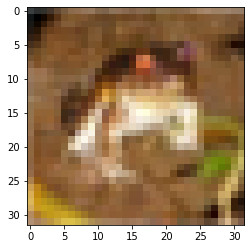

In [12]:
plt.imshow(X[0])

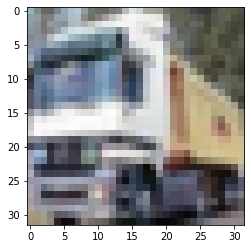

In [13]:
plt.imshow(X[1])

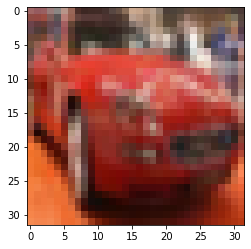

In [14]:
plt.imshow(X[5])

In [15]:
#Supporting Functions to Rearrange Data
#Encoding Labels into One-Hot Format
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [16]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [17]:
##Setting up image data: Calling CifarHelper.set_up_images()
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [18]:
##Define Supporting Functions to Build, Train, and Test CNN Model
##Initializing weights
def init_wt(filter_shape):
    init_random_dist = tf.truncated_normal(filter_shape, stddev=0.1)
    return(tf.Variable(init_random_dist))

In [19]:
##Initializing Bias
def init_bias(bias_shape):
    init_bias_vals = tf.constant(0.1, shape=bias_shape)
    return(tf.Variable(init_bias_vals))

In [20]:
##PHASE I: Build Convolutional Neural Network
import tensorflow as tf

In [21]:
##Creating convolution layer
def convolution_layer_and_dot_product(inputs, filter_shape):
    filter_init_with_wt = init_wt(filter_shape)
    conv_layer_outputs = tf.nn.conv2d(inputs, filter_init_with_wt, strides=[1, 1, 1, 1], padding='SAME')
    return (conv_layer_outputs)

In [22]:
#Relu Activation layer
def relu_and_dot_product_plus_bias(inputs, filter_shape):
    b = init_bias([filter_shape[3]])
    relu_layer_outputs = tf.nn.relu(inputs + b)
    return(relu_layer_outputs)

In [23]:
##Flatten Layer
def maxpool_2by2_and_reduce_spatial_size(inputs):
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return(pooling_layer_outputs)

In [24]:
##Fully Connected Layer
def fully_connected_layer_and_dot_product_plus_bias(inputs, output_size):
    in_size = int(inputs.get_shape()[1])
    W = init_wt([in_size, output_size])
    b = init_bias ([output_size])
    fc_xW_plus_bias_outputs = tf.matmul(inputs, W)+b
    return(fc_xW_plus_bias_outputs)

In [25]:
##Create Placeholders for Inputs and Labels: x and y_true
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record
import tensorflow as tf
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [26]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

In [39]:
##Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

In [40]:
#Create 1st Convolution Layer and so on .............
#Creating 1st convolution layer
conv_layer_1_outputs = convolution_layer_and_dot_product(x, filter_shape=[3, 3, 3, 32])
conv_relu_layer_1_outputs = relu_and_dot_product_plus_bias(conv_layer_1_outputs, filter_shape=[3, 3, 3, 32])

In [41]:
#Creating First pooling layer
pooling_layer_1_outputs = maxpool_2by2_and_reduce_spatial_size(conv_relu_layer_1_outputs)

In [42]:
#Creating 2nd convolution layer
conv_layer_2_outputs = convolution_layer_and_dot_product(pooling_layer_1_outputs, filter_shape=[3, 3, 32, 64])
conv_relu_layer_2_outputs = relu_and_dot_product_plus_bias(conv_layer_2_outputs, filter_shape=[3, 3, 32, 64])

In [43]:
#Creating Second pooling layer
pooling_layer_2_outputs = maxpool_2by2_and_reduce_spatial_size(conv_relu_layer_2_outputs)
pooling_layer_2_outputs_flat = tf.reshape(pooling_layer_2_outputs, [-1, 8*8*64])

In [44]:
#Creating first Fully connected layer
fc_layer_1_outputs \
    = fully_connected_layer_and_dot_product_plus_bias(pooling_layer_2_outputs_flat, output_size=1024)
fc_relu_layer_1_outputs = tf.nn.relu(fc_layer_1_outputs)
hold_prob = tf.placeholder(tf.float32)
fc_dropout_outputs = tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob = hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [45]:
#Creating a Final Fully connected layer
y_pred = fully_connected_layer_and_dot_product_plus_bias(fc_dropout_outputs, output_size=10)

In [46]:
#Cross Entropy Loss
softmax_cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
cross_entropy_mean = tf.reduce_mean(softmax_cross_entropy_loss)
cross_entropy_mean

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [47]:
#PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

In [48]:
#Optimizing Model using Adam
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [49]:
#Create a Model Trainer
cnn_trainer = optimizer.minimize(cross_entropy_mean)

In [50]:
#Varibale Initializer
s_initializer = tf.global_variables_initializer()

In [51]:
#Number of steps
steps = 5000

In [52]:
#Testing and Accuracy of the model
with tf.Session() as sess:
    sess.run(s_initializer)
    
    for i in range(steps):
        batch_x, batch_y = ch.next_batch(100)
        
        sess.run(cnn_trainer, feed_dict={x: batch_x, y_true: batch_y, hold_prob: 0.5})

        if i % 100 == 0:
            print('ON STEP: {}'.format(i))
            print('ACCURACY: ')
            
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            test_accuracy = sess.run (acc, feed_dict = {x: ch.test_images, \
                                                        y_true: ch.test_labels, \
                                                        hold_prob: 1.0})
            print(test_accuracy)
            print('\n')

ON STEP: 0
ACCURACY: 
0.0983


ON STEP: 100
ACCURACY: 
0.4045


ON STEP: 200
ACCURACY: 
0.4633


ON STEP: 300
ACCURACY: 
0.5304


ON STEP: 400
ACCURACY: 
0.5486


ON STEP: 500
ACCURACY: 
0.5769


ON STEP: 600
ACCURACY: 
0.5851


ON STEP: 700
ACCURACY: 
0.5759


ON STEP: 800
ACCURACY: 
0.5949


ON STEP: 900
ACCURACY: 
0.6101


ON STEP: 1000
ACCURACY: 
0.631


ON STEP: 1100
ACCURACY: 
0.6405


ON STEP: 1200
ACCURACY: 
0.6375


ON STEP: 1300
ACCURACY: 
0.6288


ON STEP: 1400
ACCURACY: 
0.6523


ON STEP: 1500
ACCURACY: 
0.6532


ON STEP: 1600
ACCURACY: 
0.6646


ON STEP: 1700
ACCURACY: 
0.6641


ON STEP: 1800
ACCURACY: 
0.6549


ON STEP: 1900
ACCURACY: 
0.6776


ON STEP: 2000
ACCURACY: 
0.6872


ON STEP: 2100
ACCURACY: 
0.686


ON STEP: 2200
ACCURACY: 
0.6882


ON STEP: 2300
ACCURACY: 
0.682


ON STEP: 2400
ACCURACY: 
0.6898


ON STEP: 2500
ACCURACY: 
0.692


ON STEP: 2600
ACCURACY: 
0.6868


ON STEP: 2700
ACCURACY: 
0.6966


ON STEP: 2800
ACCURACY: 
0.686


ON STEP: 2900
ACCURACY: 
0.6969